# Datos descargados de: https://www.pmel.noaa.gov/tao/drupal/disdel/ 



---


# PERFIL VERTICAL DE "ANOMALÍAS DE TEMPERATURA SUB SUPERFICIAL DEL MAR" DE LA BOYA UBICADA EN 0N - 170W 

---



In [924]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [925]:
# Trabajamos en colab: 
from google.colab import drive 
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/' # Directorio de trabajo
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [926]:
import pandas as pd
import xarray as xr 
from scipy.ndimage import gaussian_filter
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [927]:
ds = xr.open_dataset(path + 'BOYA 0N170W/Tsub_0N170W.cdf',
                       drop_variables = ['time_bnds','ST_6020','QT_5020','ZSST_2003','depzsst']) # Eliminamos variable inservibles.
ds['time'] = pd.date_range('1988-05-16', '2023-04-01', freq = 'D')
ds

<xarray.Dataset>
Dimensions:  (time: 12739, depth: 20, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-04-01
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
  * lat      (lat) float32 0.0
  * lon      (lon) float32 190.0
Data variables:
    T_20     (time, depth, lat, lon) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                14:27  3-APR-2023

In [928]:
# En este caso vamos a eliminar lat y lon ya que no lo utilizaremos: 
# Selecciona solo las dimensiones que deseas mantener (time y depth)
ds = ds.sel(lat=ds.lat, lon=ds.lon, method='nearest')

# Elimina las dimensiones que no deseas (lat y lon)
ds = ds.squeeze(drop=True)
ds

<xarray.Dataset>
Dimensions:  (time: 12739, depth: 20)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-04-01
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
Data variables:
    T_20     (time, depth) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                14:27  3-APR-2023

In [929]:
# Eliminamos las profundidades con pocos datos (Menos de 5000 datos)
profundidades_eliminar = [5.,   9.,  10.,  13.,  49.,  53., 103., 153., 175]

# Eliminamos y la asignamos a la misma variable del promedio histórico 
ds = ds.drop_sel(depth=profundidades_eliminar)
# # Transponer las dimensiones para que depth vaya primero
ds = ds.transpose('depth', 'time')
ds

<xarray.Dataset>
Dimensions:  (time: 12739, depth: 11)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-04-01
  * depth    (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
Data variables:
    T_20     (depth, time) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                14:27  3-APR-2023

In [930]:
# Calcular el promedio climatológico de cada día del año
clim = ds.sel(time=slice('1991-01-01', '2020-12-31')).groupby('time.dayofyear').mean(dim='time')
# Calcular la anomalía diaria en relación al promedio climatológico de cada día del año
anom = ds.groupby('time.dayofyear') - clim
anom

<xarray.Dataset>
Dimensions:  (time: 12739, depth: 11)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-04-01
  * depth    (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
    month    (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3 4
Data variables:
    T_20     (depth, time) float32 -0.8383 -0.9383 -0.9583 ... -0.01502 0.2746

In [931]:
anom.T_20.values # No hay muchos datos vacíos. 

array([[-0.8383255 , -0.938324  , -0.95832443, ..., -0.22509575,
        -0.08621979, -0.30972672],
       [        nan,         nan,         nan, ..., -0.13563156,
        -0.069664  , -0.42705536],
       [-0.7058506 , -0.8758507 , -0.9558506 , ...,  0.04177856,
         0.11137772, -0.17485046],
       ...,
       [-0.17602825,  0.2839718 ,  0.543972  , ..., -0.19583797,
         0.07105827,  0.5445614 ],
       [-0.17825031,  0.3217497 ,  0.2217493 , ...,  0.047925  ,
         0.0331831 ,  0.10822487],
       [ 0.29626083,  0.36626053,  0.2862606 , ..., -0.0033741 ,
        -0.01502228,  0.27456665]], dtype=float32)

In [932]:

def Anom(data,sigma):
  fig, ax = plt.subplots(figsize=(15, 5))
  # ----------------------------------------------------------------------------------------- 
  # Suavizado de contornos y countor fill 
  sigma = sigma
  interp_temp_smooth = gaussian_filter(data, sigma=sigma)
  # ----------------------------------------------------------------------------------------- 
  # Graficar mapa de colores suavizado
  levels = np.arange(-7, 8, 1)
  cs = ax.contourf(data.time, data.depth, interp_temp_smooth, levels, cmap="RdBu_r")

  # # Definir niveles de las líneas de contorno
  black_levels = [-6,-5,-4,-3,-2,-1,1,2,3,4,5]
  grey_levels = [level for level in levels if level not in black_levels]

  # Aplicar un suavizado a las líneas de contorno
  cs2 = ax.contour(data.time, data.depth, interp_temp_smooth, colors='black', levels=black_levels, linewidths=0.9, linestyles='-')
  cs3 = ax.contour(data.time, data.depth, interp_temp_smooth, colors='whitesmoke', levels=grey_levels, linewidths=0.5, linestyles='-')

  # # Agregar etiquetas a las líneas de contorno
  ax.clabel(cs2, fmt='%2.0f', colors='black', fontsize=12)

  # ----------------------------------------------------------------------------------------- 
  # Agregar etiquetas de valores en la barra de colores
  cbar = fig.colorbar(cs, ax=ax, ticks=np.arange(-7, 8))
  cbar.ax.tick_params(labelsize=10)
  cbar.ax.set_yticklabels(['{:.0f}'.format(i) for i in np.arange(-7, 8)])

  # Invertir el eje y y establecer límites y escala del eje y
  ax.invert_yaxis()
  ax.set_ylim(500, 0)
  ax.set_yticks(range(0, 501, 50))
  # ----------------------------------------------------------------------------------------- 
  # fechas eje x 
  fechas = [f'{year}-01', f'{year}-02', f'{year}-03', f'{year}-04', f'{year}-05', f'{year}-06', f'{year}-07', f'{year}-08', f'{year}-09', f'{year}-10', f'{year}-11', f'{year}-12']
  # Convertir fechas a objetos de fecha
  fechas_objeto = [datetime.datetime.strptime(fecha, '%Y-%m') for fecha in fechas]

  # Obtener nombres abreviados de los meses
  nombres_meses = [fecha.strftime('%b') for fecha in fechas_objeto]
  # Establecer nombres de meses en el eje x
  ax.set_xticklabels(nombres_meses)
  # #----------------------------------------------------------------------------------------- 
    # ESTILO :V 
  ax.set_title(f'Anomalía de Temperatura [°C] Sub Superficial del mar\nAño: {year} - Boya: 0N 170W', fontsize=14, color = 'black')
  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')

  plt.xticks(fontsize = 12, rotation=360)
  plt.yticks(fontsize = 12, rotation=360)
  ax.set_xlabel('')

  plt.text(0, -0.15, 'Fuente de datos: NOAA [TAO/TRITON]', fontsize=12, ha='left', 
        va='center', color='black', transform=plt.gca().transAxes)
  #-----------------------------------------------------------------------------------------  
  fig.savefig(path + f'BOYA 0N170W/AnomTempSub{year}.jpg', 
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
  plt.show()
  plt.close()

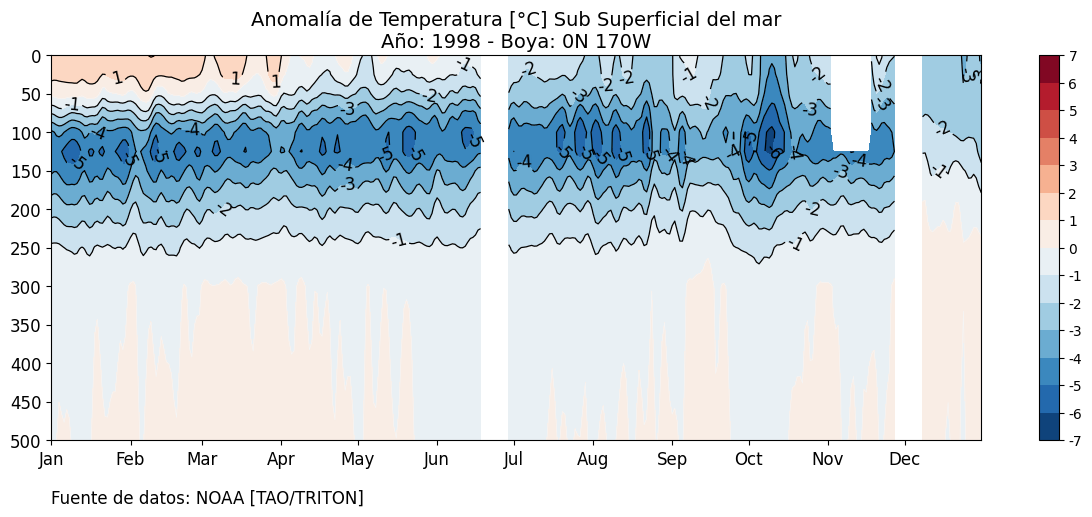

In [933]:
years = [1998]
for year in years:
  Anom(anom.T_20.sel(time=slice(f'{year}-01-01',f'{year}-12-31')),1)
# NO PUEDE SEEEEERRRR HAY DATOS VACÍOS :O ... Vamos a interpolar xd   

# INTERPOLACIÓN 

In [934]:
# Realizar la interpolación
anom_interp = anom.interpolate_na(dim='time')
anom_interp

<xarray.Dataset>
Dimensions:  (time: 12739, depth: 11)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-04-01
  * depth    (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
    month    (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3 4
Data variables:
    T_20     (depth, time) float32 -0.8383 -0.9383 -0.9583 ... -0.01502 0.2746

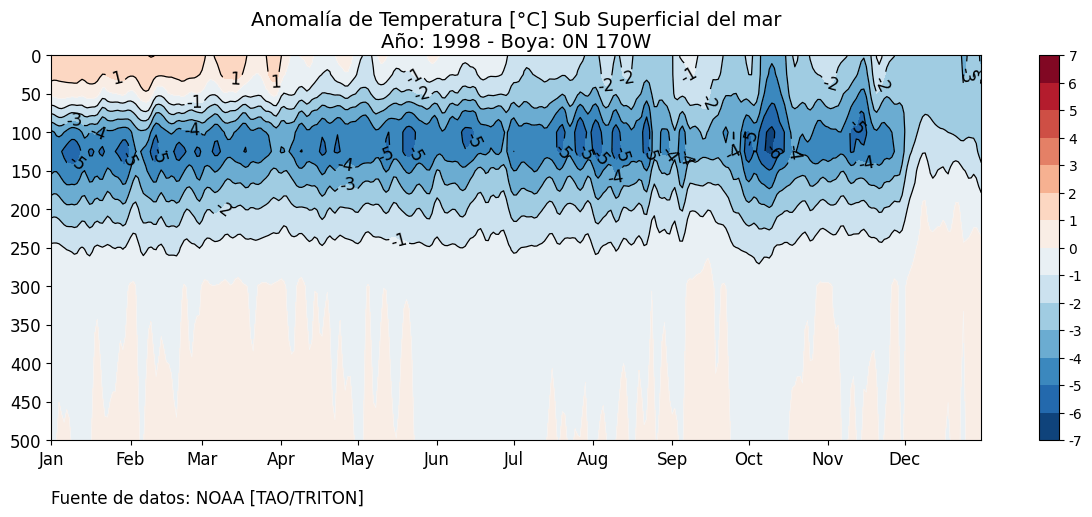

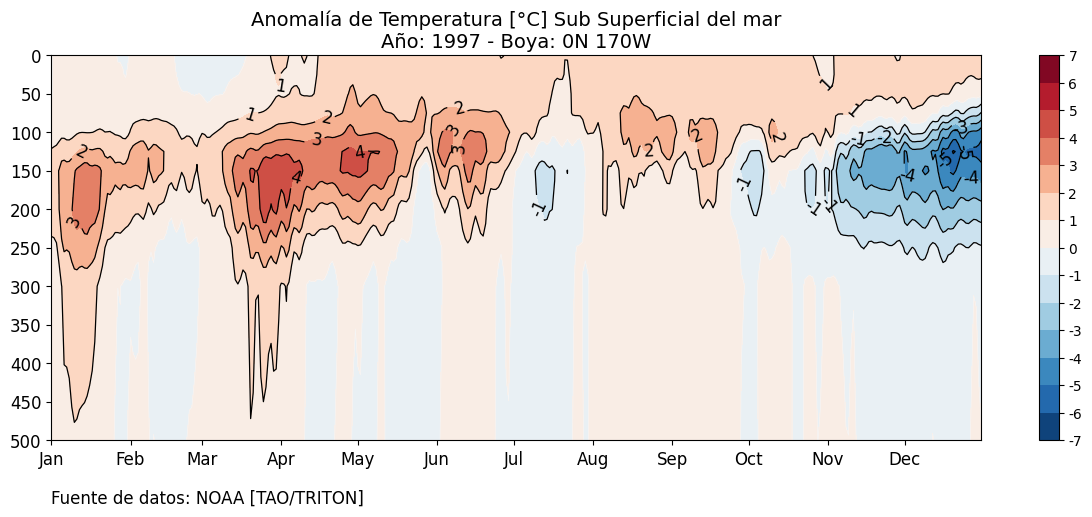

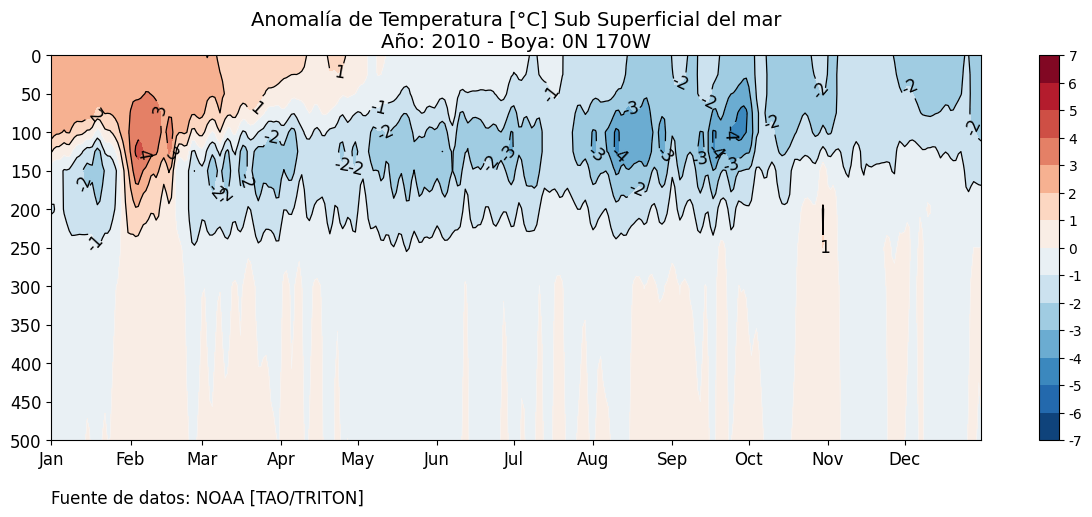

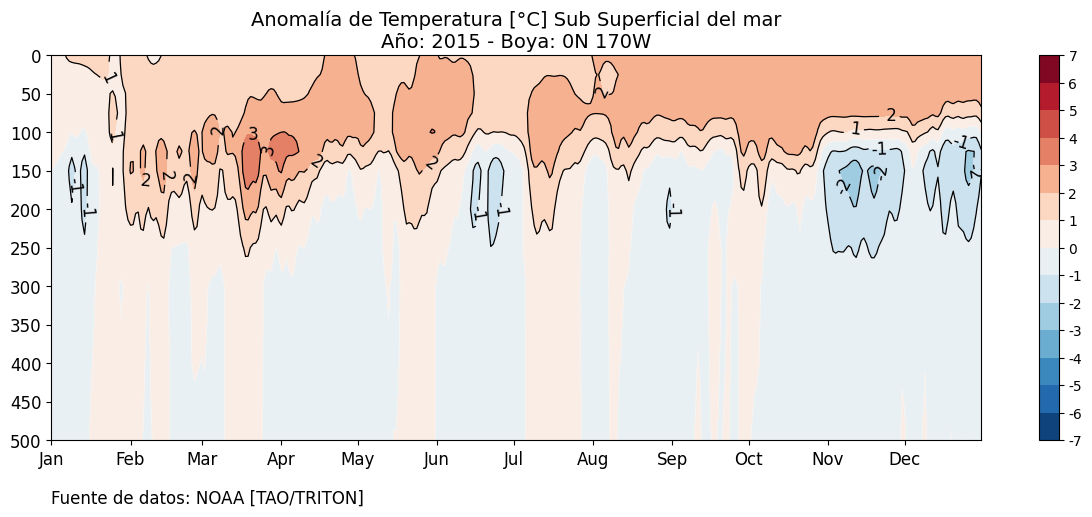

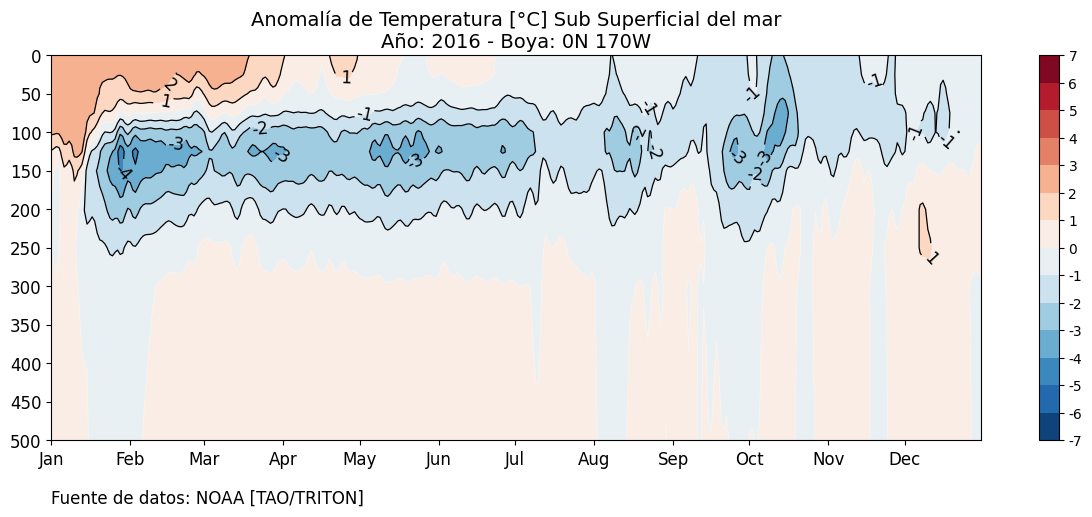

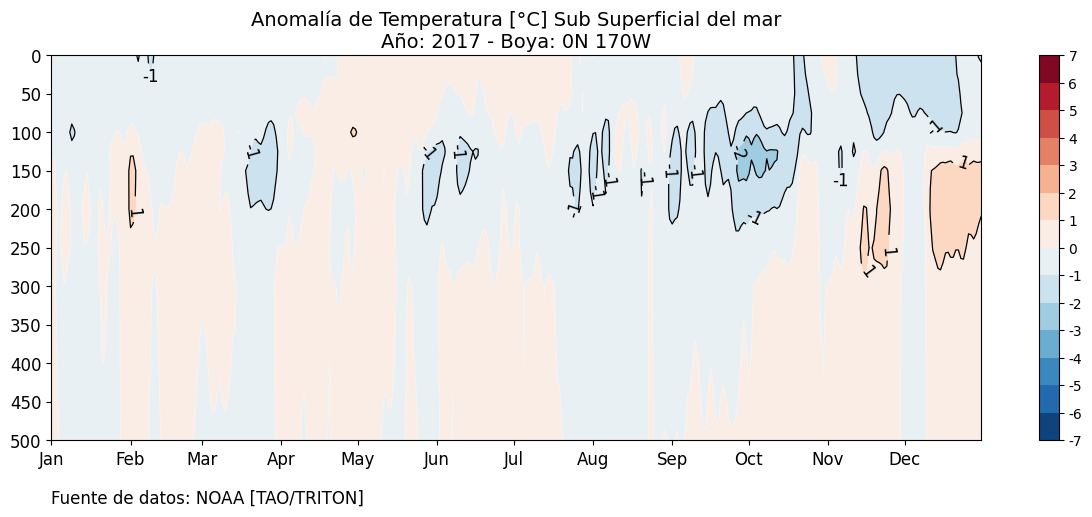

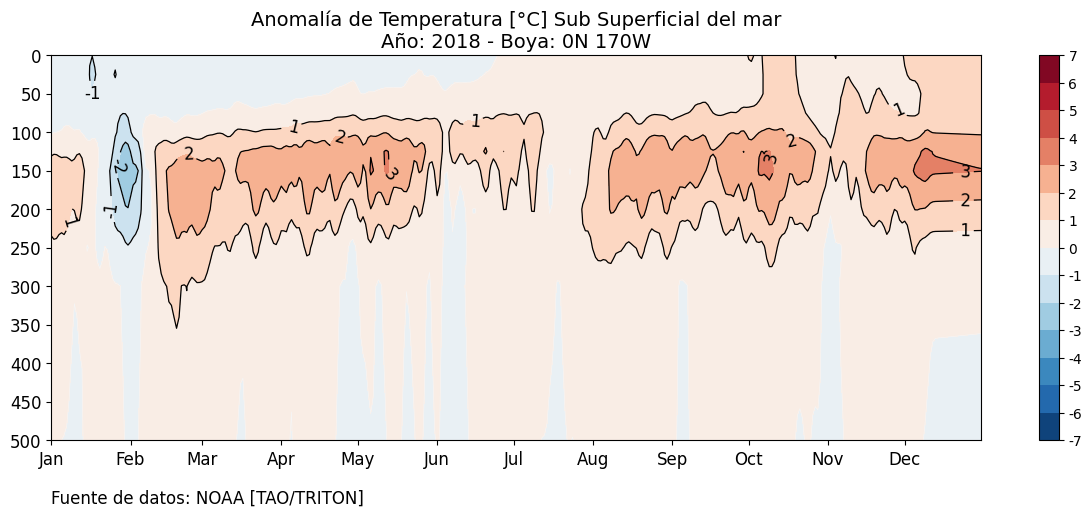

In [935]:
years = [1998,1997,2010,2015,2016,2017,2018]
for year in years:
  Anom(anom_interp.T_20.sel(time=slice(f'{year}-01-01',f'{year}-12-31')),1)



---
# Los datos utilizados se encuentran en el siguiente link: 
https://drive.google.com/drive/u/0/folders/1h6Zx1Xf3JztHvRN6L_TMBlB1SVhiHf6a



---

